# NB02: Composite Scoring — Ecotype Species Screening

**Run on**: Local machine (reads CSVs from `../data/` produced by NB01)

## Goal

Combine the three data dimensions from NB01 into a composite ecotype candidate score for each of the 338 tree species.

## Scoring Dimensions

| Dimension | Source Column | Rationale |
|-----------|--------------|----------|
| **Phylogenetic substructure** | `cv_branch_dist` | High CV → possible ecotype clusters |
| **Environmental diversity** | `env_broad_entropy` | High entropy → spans many environments |
| **Pangenome openness** | `singleton_fraction` | High singleton fraction → more gene content variation |

Each dimension is z-scored independently; the composite is the mean z-score.
Species with zero env coverage receive `env_broad_entropy = 0` (score is still meaningful — they rank low on this dimension only).

## Tests

1. **H1** — Pearson correlation between `cv_branch_dist` and `env_broad_entropy`
2. **H3** — Are the top-25 scoring species underrepresented in `ecotype_analysis` (213 prior species)?

In [1]:
# Cell 1: Imports and load data

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats

DATA_PATH = "../data"
FIG_PATH = "../figures"
os.makedirs(FIG_PATH, exist_ok=True)

# Load extracted data
phylo = pd.read_csv(f"{DATA_PATH}/species_phylo_stats.csv")
pangenome = pd.read_csv(f"{DATA_PATH}/species_pangenome_stats.csv")
env = pd.read_csv(f"{DATA_PATH}/species_env_stats.csv")
prior = pd.read_csv("../../ecotype_analysis/data/ecotype_correlation_results.csv")

print(f"Phylo stats: {len(phylo)} species")
print(f"Pangenome stats: {len(pangenome)} species")
print(f"Env stats: {len(env)} species")
print(f"Prior ecotype_analysis: {len(prior)} species")

Phylo stats: 338 species
Pangenome stats: 338 species
Env stats: 338 species
Prior ecotype_analysis: 213 species


In [2]:
# Cell 2: Merge all dimensions into one DataFrame

df = (
    phylo[['gtdb_species_clade_id', 'GTDB_species', 'n_genomes_in_tree',
           'cv_branch_dist', 'std_branch_dist', 'mean_branch_dist',
           'max_branch_dist', 'median_branch_dist', 'max_median_ratio']]
    .merge(
        pangenome[['gtdb_species_clade_id', 'no_genomes', 'no_core', 'no_aux_genome',
                   'no_singleton_gene_clusters', 'no_gene_clusters',
                   'singleton_fraction', 'core_fraction', 'aux_fraction',
                   'mean_intra_species_ANI']],
        on='gtdb_species_clade_id', how='left'
    )
    .merge(
        env[['gtdb_species_clade_id', 'n_genomes_with_env', 'n_distinct_env_broad',
              'env_broad_entropy', 'env_coverage_fraction']],
        on='gtdb_species_clade_id', how='left'
    )
)

# Fill missing env values with 0 (no env coverage)
df['env_broad_entropy'] = df['env_broad_entropy'].fillna(0.0)
df['n_distinct_env_broad'] = df['n_distinct_env_broad'].fillna(0)
df['env_coverage_fraction'] = df['env_coverage_fraction'].fillna(0.0)

# Flag species in prior ecotype_analysis
prior_species = set(prior['species'].tolist())
df['in_prior_ecotype_analysis'] = df['gtdb_species_clade_id'].isin(prior_species)

print(f"Merged dataset: {len(df)} species")
print(f"Species also in prior ecotype_analysis: {df['in_prior_ecotype_analysis'].sum()}")
print(f"Species NOT in prior ecotype_analysis: {(~df['in_prior_ecotype_analysis']).sum()}")
print(f"\nMissing CV values: {df['cv_branch_dist'].isna().sum()}")
print(df[['cv_branch_dist', 'env_broad_entropy', 'singleton_fraction']].describe())

Merged dataset: 338 species
Species also in prior ecotype_analysis: 99
Species NOT in prior ecotype_analysis: 239

Missing CV values: 0
       cv_branch_dist  env_broad_entropy  singleton_fraction
count      338.000000       3.380000e+02          338.000000
mean         0.561952       1.446630e+00            0.478696
std          0.451880       9.521880e-01            0.086972
min          0.118667      -1.442823e-12            0.027297
25%          0.337553       6.966971e-01            0.427241
50%          0.461460       1.479748e+00            0.491072
75%          0.654129       2.190829e+00            0.533985
max          5.844860       3.615519e+00            0.691264


In [3]:
# Cell 3: Z-score the three dimensions and compute composite score

def zscore_robust(series, clip=5):
    """Z-score with clipping to reduce sensitivity to extreme outliers."""
    z = (series - series.mean()) / series.std()
    return z.clip(-clip, clip)

df['z_phylo'] = zscore_robust(df['cv_branch_dist'].fillna(0))
df['z_env']   = zscore_robust(df['env_broad_entropy'].fillna(0))
df['z_open']  = zscore_robust(df['singleton_fraction'].fillna(0))

# Composite = mean of the three z-scores (equal weighting)
df['composite_score'] = df[['z_phylo', 'z_env', 'z_open']].mean(axis=1)

df = df.sort_values('composite_score', ascending=False).reset_index(drop=True)
df['rank'] = df.index + 1

# Short display name
df['short_name'] = df['GTDB_species'].str.replace('s__', '').str.replace('_', ' ')

print("Top 20 candidates by composite score:")
display_cols = ['rank', 'short_name', 'no_genomes', 'cv_branch_dist',
                'env_broad_entropy', 'singleton_fraction', 'composite_score',
                'in_prior_ecotype_analysis']
print(df.head(20)[display_cols].to_string(index=False))

Top 20 candidates by composite score:
 rank                    short_name  no_genomes  cv_branch_dist  env_broad_entropy  singleton_fraction  composite_score  in_prior_ecotype_analysis
    1 Prochlorococcus A sp000635495          74        5.844860           0.522849            0.691264         2.157974                       True
    2       Akkermansia sp004167605          73        2.731984           0.323169            0.550738         1.483563                       True
    3      Bifidobacterium animalis         115        1.532511           2.450925            0.571242         1.422211                      False
    4             Erwinia amylovora         231        2.061939           1.483356            0.551664         1.398995                      False
    5    Staphylococcus epidermidis        1315        0.942551           2.906233            0.623100         1.345162                      False
    6        Francisella tularensis         852        1.852732           1.5219

In [4]:
# Cell 4: Save scored species table

df.to_csv(f"{DATA_PATH}/species_scored.csv", index=False)
print(f"Saved species_scored.csv ({len(df)} species)")

Saved species_scored.csv (338 species)


---
## H1: Does Phylogenetic Substructure Correlate with Environmental Diversity?

H1 Test: Phylogenetic substructure (CV) vs Environmental diversity (entropy)
  N species with env annotations: 292
  Pearson r = -0.171  (p = 0.0034)
  Spearman rho = -0.111  (p = 0.0582)
  -> Significant negative correlation (alpha=0.05). H1 supported.


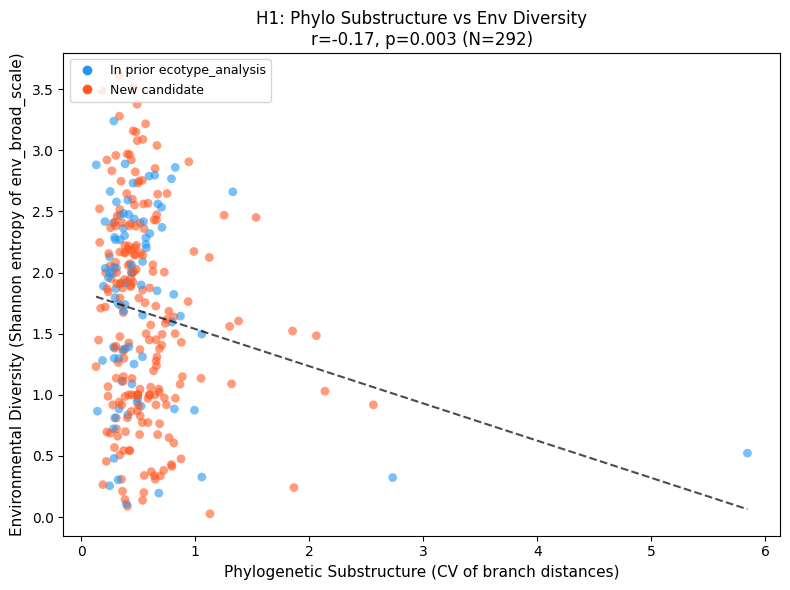

Saved h1_phylo_vs_env_scatter.png


In [5]:
# Cell 5: Test H1 — Pearson correlation between CV and env entropy

# Use only species with any env annotation
h1_df = df[df['env_broad_entropy'] > 0].dropna(subset=['cv_branch_dist', 'env_broad_entropy'])

r, p = stats.pearsonr(h1_df['cv_branch_dist'], h1_df['env_broad_entropy'])
rho, p_spearman = stats.spearmanr(h1_df['cv_branch_dist'], h1_df['env_broad_entropy'])

print(f"H1 Test: Phylogenetic substructure (CV) vs Environmental diversity (entropy)")
print(f"  N species with env annotations: {len(h1_df)}")
print(f"  Pearson r = {r:.3f}  (p = {p:.4f})")
print(f"  Spearman rho = {rho:.3f}  (p = {p_spearman:.4f})")
if p < 0.05:
    direction = 'positive' if r > 0 else 'negative'
    print(f"  -> Significant {direction} correlation (alpha=0.05). H1 supported.")
else:
    print(f"  -> No significant correlation at alpha=0.05. H0 not rejected.")

# Scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
colors = h1_df['in_prior_ecotype_analysis'].map({True: '#2196F3', False: '#FF5722'})
ax.scatter(h1_df['cv_branch_dist'], h1_df['env_broad_entropy'],
           c=colors, alpha=0.6, s=40, edgecolors='none')

# Regression line
m, b = np.polyfit(h1_df['cv_branch_dist'], h1_df['env_broad_entropy'], 1)
x_line = np.linspace(h1_df['cv_branch_dist'].min(), h1_df['cv_branch_dist'].max(), 100)
ax.plot(x_line, m * x_line + b, 'k--', linewidth=1.5, alpha=0.7)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2196F3', label='In prior ecotype_analysis', markersize=8),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF5722', label='New candidate', markersize=8),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=9)

ax.set_xlabel('Phylogenetic Substructure (CV of branch distances)', fontsize=11)
ax.set_ylabel('Environmental Diversity (Shannon entropy of env_broad_scale)', fontsize=11)
ax.set_title(f'H1: Phylo Substructure vs Env Diversity\nr={r:.2f}, p={p:.3f} (N={len(h1_df)})', fontsize=12)
plt.tight_layout()
plt.savefig(f"{FIG_PATH}/h1_phylo_vs_env_scatter.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved h1_phylo_vs_env_scatter.png")

---
## H3: Are Top Candidates Underrepresented in Prior Work?

In [6]:
# Cell 6: Test H3 — Top candidates underrepresented in prior ecotype_analysis?

# Define top quartile by composite score as "top candidates"
top25_pct = df['composite_score'].quantile(0.75)
df['is_top_candidate'] = df['composite_score'] >= top25_pct

n_top = df['is_top_candidate'].sum()
n_top_in_prior = (df['is_top_candidate'] & df['in_prior_ecotype_analysis']).sum()
n_all_in_prior = df['in_prior_ecotype_analysis'].sum()

# Fisher's exact test: is prior analysis depleted of top candidates?
# Contingency table:
#              In prior | Not in prior
# Top           a       |     b
# Not top       c       |     d
a = n_top_in_prior
b = n_top - n_top_in_prior
c = n_all_in_prior - n_top_in_prior
d = len(df) - n_top - c
oddsratio, p_fisher = stats.fisher_exact([[a, b], [c, d]], alternative='less')

print(f"H3 Test: Are top candidates underrepresented in prior ecotype_analysis?")
print(f"  Total species: {len(df)}")
print(f"  Top candidates (top 25% by composite score): {n_top}")
print(f"  In prior ecotype_analysis: {n_all_in_prior} total ({100*n_all_in_prior/len(df):.0f}%)")
print(f"  Top candidates also in prior: {n_top_in_prior}/{n_top} ({100*n_top_in_prior/n_top:.0f}%)")
print(f"  Non-top candidates in prior: {c}/{len(df)-n_top} ({100*c/(len(df)-n_top):.0f}%)")
print(f"  Fisher's exact (one-sided 'less'): OR={oddsratio:.2f}, p={p_fisher:.4f}")
if p_fisher < 0.05:
    print(f"  -> Top candidates significantly underrepresented in prior work (H3 supported).")
else:
    print(f"  -> No significant depletion of top candidates in prior work (H3 not supported).")

print(f"\nTop 25 new candidates (NOT in prior ecotype_analysis):")
new_candidates = df[~df['in_prior_ecotype_analysis']].head(25)
print(new_candidates[['rank', 'short_name', 'no_genomes', 'cv_branch_dist',
                       'env_broad_entropy', 'composite_score']].to_string(index=False))

H3 Test: Are top candidates underrepresented in prior ecotype_analysis?
  Total species: 338
  Top candidates (top 25% by composite score): 85
  In prior ecotype_analysis: 99 total (29%)
  Top candidates also in prior: 30/85 (35%)
  Non-top candidates in prior: 69/253 (27%)
  Fisher's exact (one-sided 'less'): OR=1.45, p=0.9373
  -> No significant depletion of top candidates in prior work (H3 not supported).

Top 25 new candidates (NOT in prior ecotype_analysis):
 rank                    short_name  no_genomes  cv_branch_dist  env_broad_entropy  composite_score
    3      Bifidobacterium animalis         115        1.532511           2.450925         1.422211
    4             Erwinia amylovora         231        2.061939           1.483356         1.398995
    5    Staphylococcus epidermidis        1315        0.942551           2.906233         1.345162
    6        Francisella tularensis         852        1.852732           1.521928         1.255934
    8      Listeria monocytogene

---
## Score Distribution Visualizations

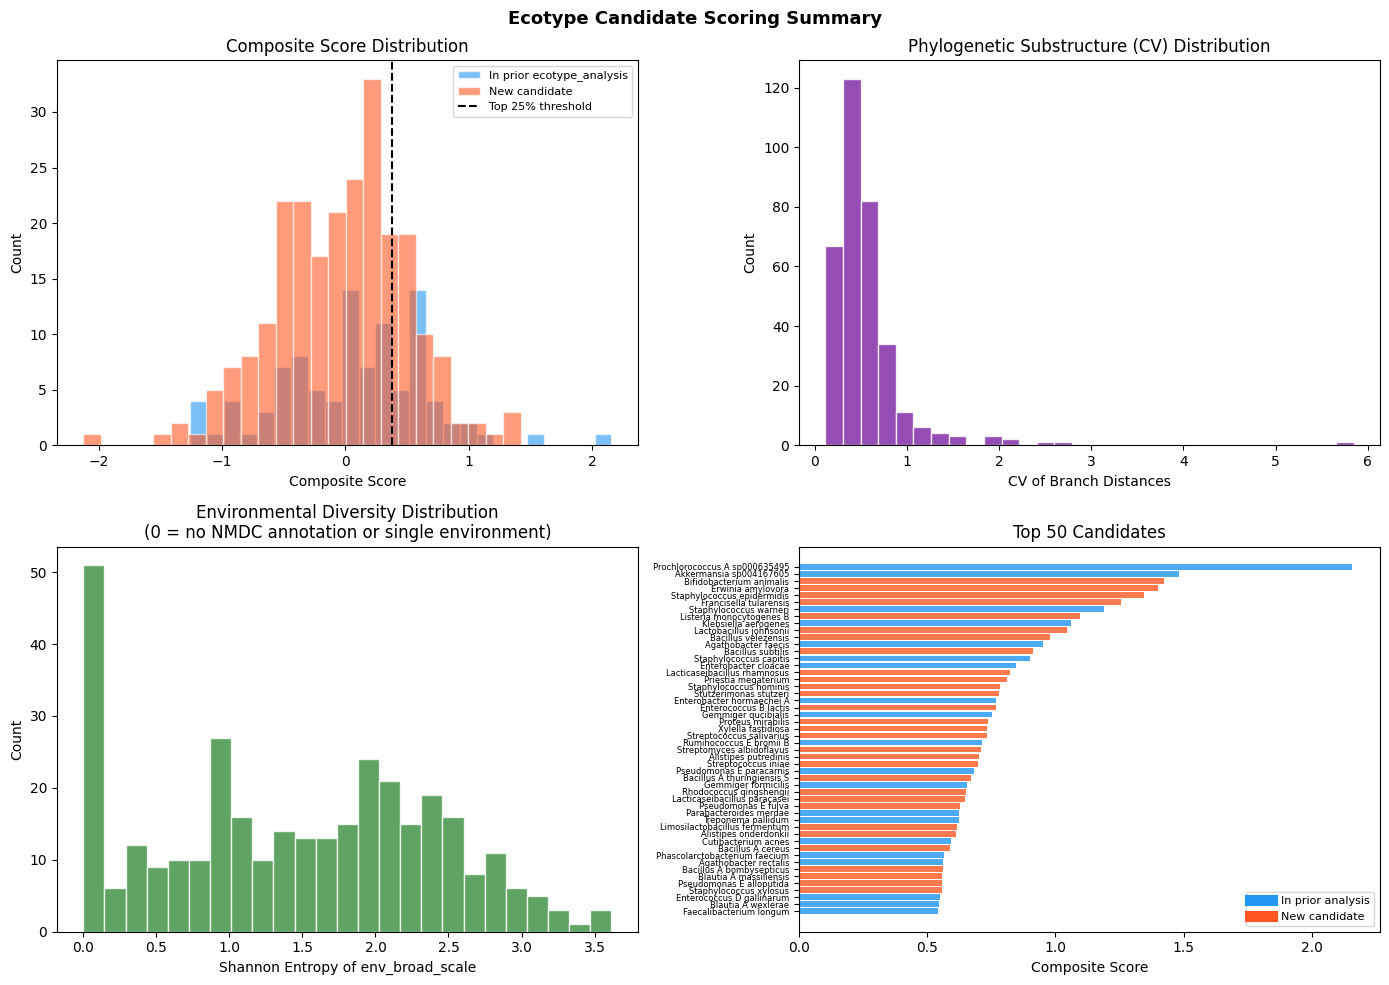

Saved scoring_overview.png


In [7]:
# Cell 7: Score distribution plots

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Composite score distribution
ax = axes[0, 0]
colors_hist = ['#2196F3' if v else '#FF5722' for v in df['in_prior_ecotype_analysis']]
ax.hist(df[df['in_prior_ecotype_analysis']]['composite_score'], bins=25,
        alpha=0.6, color='#2196F3', label='In prior ecotype_analysis', edgecolor='white')
ax.hist(df[~df['in_prior_ecotype_analysis']]['composite_score'], bins=25,
        alpha=0.6, color='#FF5722', label='New candidate', edgecolor='white')
ax.axvline(top25_pct, color='black', linestyle='--', linewidth=1.5, label='Top 25% threshold')
ax.set_xlabel('Composite Score')
ax.set_ylabel('Count')
ax.set_title('Composite Score Distribution')
ax.legend(fontsize=8)

# 2. Phylo CV distribution
ax = axes[0, 1]
ax.hist(df['cv_branch_dist'].dropna(), bins=30, color='#7B1FA2', alpha=0.8, edgecolor='white')
ax.set_xlabel('CV of Branch Distances')
ax.set_ylabel('Count')
ax.set_title('Phylogenetic Substructure (CV) Distribution')

# 3. Env entropy distribution
ax = axes[1, 0]
ax.hist(df['env_broad_entropy'], bins=25, color='#388E3C', alpha=0.8, edgecolor='white')
ax.set_xlabel('Shannon Entropy of env_broad_scale')
ax.set_ylabel('Count')
ax.set_title(f'Environmental Diversity Distribution\n(0 = no NMDC annotation or single environment)')

# 4. Composite rank dotplot — top 50
ax = axes[1, 1]
top50 = df.head(50)
colors_rank = ['#2196F3' if v else '#FF5722' for v in top50['in_prior_ecotype_analysis']]
ax.barh(range(len(top50)), top50['composite_score'], color=colors_rank, alpha=0.8)
ax.set_yticks(range(len(top50)))
ax.set_yticklabels([s[:30] for s in top50['short_name']], fontsize=6)
ax.invert_yaxis()
ax.set_xlabel('Composite Score')
ax.set_title('Top 50 Candidates')
from matplotlib.lines import Line2D
ax.legend(handles=[
    Line2D([0], [0], color='#2196F3', lw=8, label='In prior analysis'),
    Line2D([0], [0], color='#FF5722', lw=8, label='New candidate'),
], fontsize=8)

plt.suptitle('Ecotype Candidate Scoring Summary', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{FIG_PATH}/scoring_overview.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved scoring_overview.png")

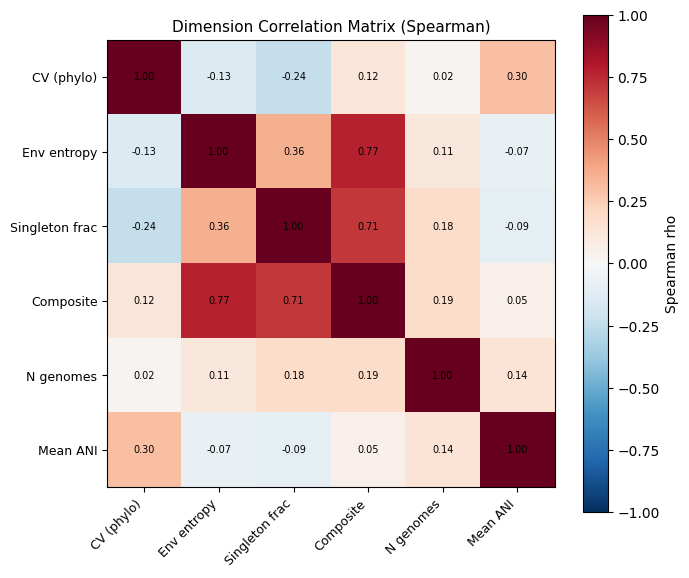

Saved dimension_correlations.png


In [8]:
# Cell 8: Dimension correlation heatmap

dims = ['cv_branch_dist', 'env_broad_entropy', 'singleton_fraction',
        'composite_score', 'no_genomes', 'mean_intra_species_ANI']
corr = df[dims].corr(method='spearman')

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im, ax=ax, label='Spearman rho')
ax.set_xticks(range(len(dims)))
ax.set_yticks(range(len(dims)))
labels = ['CV (phylo)', 'Env entropy', 'Singleton frac',
          'Composite', 'N genomes', 'Mean ANI']
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(labels, fontsize=9)
for i in range(len(dims)):
    for j in range(len(dims)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', fontsize=7)
ax.set_title('Dimension Correlation Matrix (Spearman)', fontsize=11)
plt.tight_layout()
plt.savefig(f"{FIG_PATH}/dimension_correlations.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved dimension_correlations.png")

In [9]:
# Cell 9: Final summary

print("=== SCORING COMPLETE ===")
print(f"Species scored: {len(df)}")
print(f"Top 25% candidates: {n_top}  ({n_top - n_top_in_prior} are new, {n_top_in_prior} already analyzed)")
print()
print("Top 10 NEW candidates (highest composite score, not in prior analysis):")
top_new = df[~df['in_prior_ecotype_analysis']].head(10)
for _, row in top_new.iterrows():
    print(f"  #{row['rank']:3d}  {row['short_name']:<45}  "
          f"CV={row['cv_branch_dist']:.3f}  "
          f"Henv={row['env_broad_entropy']:.2f}  "
          f"open={row['singleton_fraction']:.2f}  "
          f"score={row['composite_score']:.2f}")
print()
print("Next: NB03 retrospective validation (H2) against prior ecotype_analysis results.")

=== SCORING COMPLETE ===
Species scored: 338
Top 25% candidates: 85  (55 are new, 30 already analyzed)

Top 10 NEW candidates (highest composite score, not in prior analysis):
  #  3  Bifidobacterium animalis                       CV=1.533  Henv=2.45  open=0.57  score=1.42
  #  4  Erwinia amylovora                              CV=2.062  Henv=1.48  open=0.55  score=1.40
  #  5  Staphylococcus epidermidis                     CV=0.943  Henv=2.91  open=0.62  score=1.35
  #  6  Francisella tularensis                         CV=1.853  Henv=1.52  open=0.55  score=1.26
  #  8  Listeria monocytogenes B                       CV=1.252  Henv=2.47  open=0.54  score=1.09
  # 10  Lactobacillus johnsonii                        CV=0.402  Henv=2.97  open=0.64  score=1.05
  # 11  Bacillus velezensis                            CV=0.328  Henv=3.62  open=0.58  score=0.98
  # 13  Bacillus subtilis                              CV=0.461  Henv=3.52  open=0.55  score=0.91
  # 16  Lacticaseibacillus rhamnosus    